In [1]:
import random
random.seed(100)
from negmas import *
import math
from negmas.preferences.value_fun import *
from rich import print
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size


def savefig(name, fig=None):
    if fig is None:
        fig = plt.gcf()
    for ext in ("pdf", "png"):
        plt.savefig(f"{name}.{ext}", pad_inches=0.0, bbox_inches="tight")
        

# NegMAS: A platform for Automated Negotiation

## Yasser Mohammad and Amy Greenwald
### AAAI 2022 Tutorial

## What is NegMAS?

- A platform for developing negotiators with special attention to **situated negotiation**
- Can be used to simulate general MAS systems but is geared toward AN
- Have *limited* interoperability with GENIUS
- 100% python

![negmas](world.pdf)

## A simple negotiation

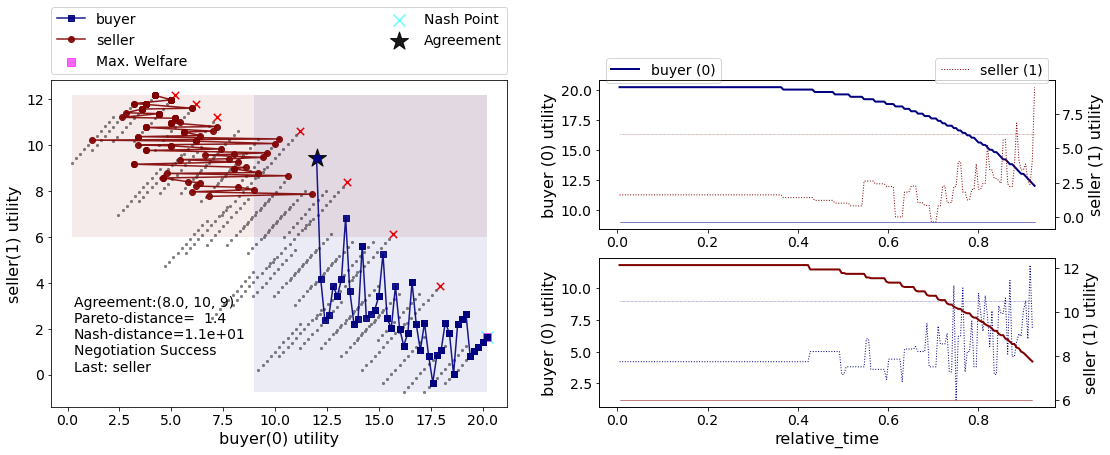

In [2]:
# create negotiation agenda (issues)
issues = [ make_issue(name='price', values=(0.0, 9.0)), 
           make_issue(name='quantity', values=(1, 11)), 
           make_issue(name='delivery_time', values=10) ]
# create the mechanism
session = SAOMechanism(issues=issues, n_steps=200)
# define buyer and seller utilities
buyer_utility = LinearAdditiveUtilityFunction(
        values={ 'price': AffineFun(-1, bias=9.0), 'quantity': LinearFun(0.2),  'delivery_time': IdentityFun() },
        outcome_space=session.outcome_space, reserved_value=9 )

seller_utility =  LinearAdditiveUtilityFunction(
        values=[ IdentityFun(),  LinearFun(0.2),  lambda x: math.sin(2 * math.pi * x / 10)  ],
        reserved_value=6)

# create and add buyer and seller negotiators
session.add(BoulwareTBNegotiator(name='buyer'), ufun=buyer_utility)
session.add(BoulwareTBNegotiator(name='seller', preferences=seller_utility))

# run the negotiation and show the results
session.run(); session.plot(show_agreement=True)
savefig("buyerseller")

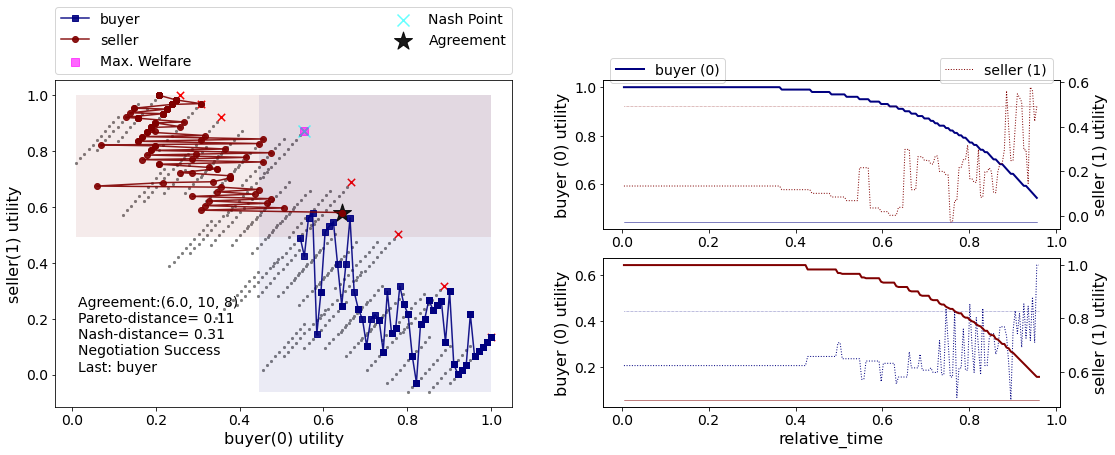

In [3]:
# create negotiation agenda (issues)
issues = [ make_issue(name='price', values=(0.0, 9.0)), 
           make_issue(name='quantity', values=(1, 11)), 
           make_issue(name='delivery_time', values=10) ]
# create the mechanism
session = SAOMechanism(issues=issues, n_steps=200)
# define buyer and seller utilities
buyer_utility = LinearAdditiveUtilityFunction(
        values={ 'price': AffineFun(-1, bias=9.0), 'quantity': LinearFun(0.2),  'delivery_time': IdentityFun() },
        outcome_space=session.outcome_space, reserved_value=9).scale_max(1.0)

seller_utility =  LinearAdditiveUtilityFunction(
        values=[ IdentityFun(),  LinearFun(0.2),  lambda x: math.sin(2 * math.pi * x / 10)  ],
        outcome_space=session.outcome_space, reserved_value=6).scale_max(1.0)

# create and add buyer and seller negotiators
session.add(BoulwareTBNegotiator(name='buyer'), ufun=buyer_utility)
session.add(BoulwareTBNegotiator(name='seller', preferences=seller_utility))

# run the negotiation and show the results
session.run(); session.plot(show_agreement=True)
savefig("buyerseller_scaled")

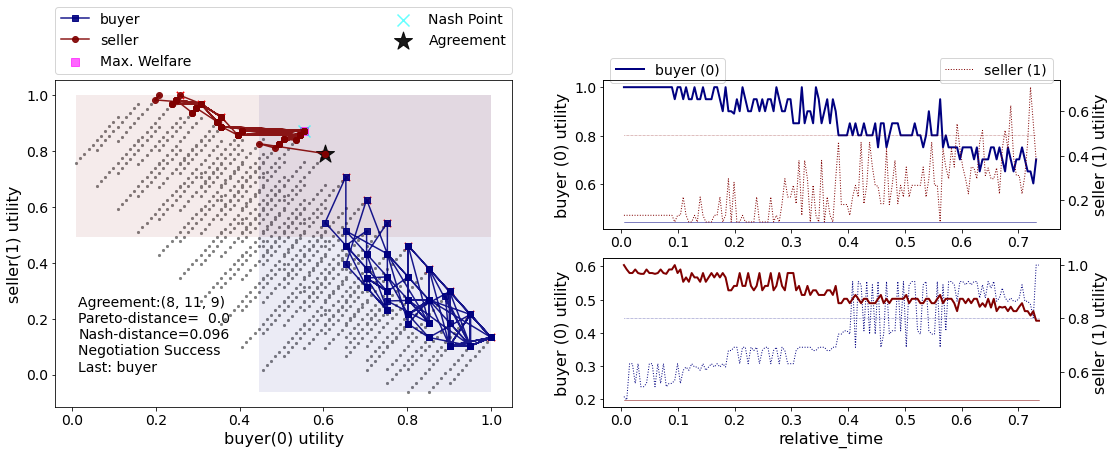

In [6]:
# create negotiation agenda (issues)
issues = [ make_issue(name='price', values=(10)), 
           make_issue(name='quantity', values=(1, 11)), 
           make_issue(name='delivery_time', values=10) ]
# create the mechanism
session = SAOMechanism(issues=issues, n_steps=200)
# define buyer and seller utilities
buyer_utility = LinearAdditiveUtilityFunction(
        values={ 'price': AffineFun(-1, bias=9.0), 'quantity': LinearFun(0.2),  'delivery_time': IdentityFun() },
        outcome_space=session.outcome_space, reserved_value=9).scale_max(1.0)

seller_utility =  LinearAdditiveUtilityFunction(
        values=[ IdentityFun(),  LinearFun(0.2),  lambda x: math.sin(2 * math.pi * x / 10)  ],
        outcome_space=session.outcome_space, reserved_value=6).scale_max(1.0)

# create and add buyer and seller negotiators
session.add(Atlas3(name='buyer'), ufun=buyer_utility)
session.add(NiceTitForTat(name='seller', preferences=seller_utility))

# run the negotiation and show the results
session.run(); session.plot(show_agreement=True)
savefig("buyerseller_genius")

In [7]:
class CosNegotiator(SAONegotiator):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def on_preferences_changed(self, changes):
        super().on_preferences_changed(changes)
        self._inv = PresortingInverseUtilityFunction(self.ufun)
        self._inv.init()
    
    def propose(self, state):
        u = math.cos(state.relative_time * 4 * math.pi)
        return self._inv.worst_in((u, u + 0.1))
        

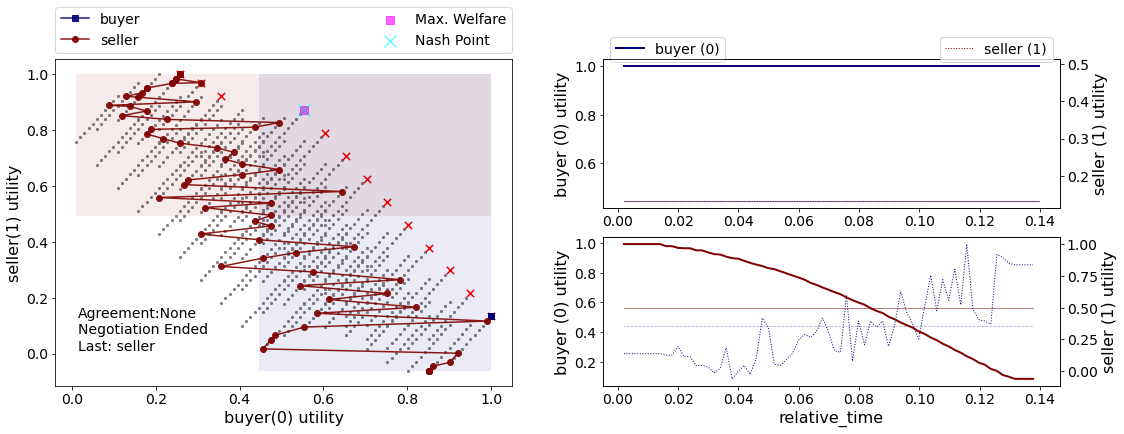

In [8]:
# create negotiation agenda (issues)
issues = [ make_issue(name='price', values=10), 
           make_issue(name='quantity', values=(1, 11)), 
           make_issue(name='delivery_time', values=10) ]
# create the mechanism
session = SAOMechanism(issues=issues, n_steps=500)
# define buyer and seller utilities
buyer_utility = LinearAdditiveUtilityFunction(
        values={ 'price': AffineFun(-1, bias=9.0), 'quantity': LinearFun(0.2),  'delivery_time': IdentityFun() },
        outcome_space=session.outcome_space, reserved_value=9).scale_max(1.0)

seller_utility =  LinearAdditiveUtilityFunction(
        values=[ IdentityFun(),  LinearFun(0.2),  lambda x: math.sin(2 * math.pi * x / 10)  ],
        outcome_space=session.outcome_space, reserved_value=6).scale_max(1.0)

# create and add buyer and seller negotiators
session.add(BoulwareTBNegotiator(name='buyer'), ufun=buyer_utility)
session.add(CosNegotiator(name='seller', preferences=seller_utility))

# run the negotiation and show the results
session.run(); session.plot(show_agreement=True)
savefig("buyerseller_cos1")

In [9]:
class CosNegotiator(SAONegotiator):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def on_preferences_changed(self, changes):
        super().on_preferences_changed(changes)
        self._inv = PresortingInverseUtilityFunction(self.ufun)
        self._inv.init()
        self._min, self._max = self.ufun.minmax()
        if self.reserved_value > self._min:
            self._min = self.reserved_value
    
    def propose(self, state):
        u = math.cos(state.relative_time * math.pi / 2) * (self._max - self._min) + self._min
        return self._inv.worst_in((u, self._max))
        

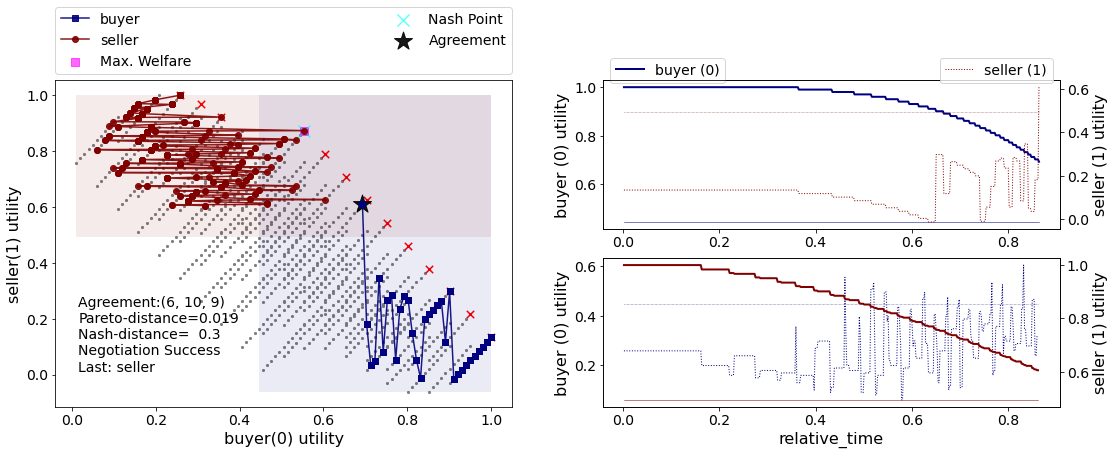

In [10]:
# create negotiation agenda (issues)
issues = [ make_issue(name='price', values=10), 
           make_issue(name='quantity', values=(1, 11)), 
           make_issue(name='delivery_time', values=10) ]
# create the mechanism
session = SAOMechanism(issues=issues, n_steps=500)
# define buyer and seller utilities
buyer_utility = LinearAdditiveUtilityFunction(
        values={ 'price': AffineFun(-1, bias=9.0), 'quantity': LinearFun(0.2),  'delivery_time': IdentityFun() },
        outcome_space=session.outcome_space, reserved_value=9).scale_max(1.0)

seller_utility =  LinearAdditiveUtilityFunction(
        values=[ IdentityFun(),  LinearFun(0.2),  lambda x: math.sin(2 * math.pi * x / 10)  ],
        outcome_space=session.outcome_space, reserved_value=6).scale_max(1.0)

# create and add buyer and seller negotiators
session.add(BoulwareTBNegotiator(name='buyer'), ufun=buyer_utility)
session.add(CosNegotiator(name='seller', preferences=seller_utility))

# run the negotiation and show the results
session.run(); session.plot(show_agreement=True)
savefig("buyerseller_cos2")

In [21]:
class CosNegotiator(SAONegotiator):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._best_so_far, self._max_received = None, float("-inf") 

    def on_preferences_changed(self, changes):
        super().on_preferences_changed(changes)
        self._inv = PresortingInverseUtilityFunction(self.ufun)
        self._inv.init()
        self._min, self._max = self.ufun.minmax()
        if self.reserved_value > self._min:
            self._min = self.reserved_value
    
    def respond(self, state, offer):
        u = self.ufun(offer)
        if u >= self._max_received:
            self._max_received = u
            self._best_so_far = offer
        if u > self.asp(state):
            return ResponseType.ACCEPT_OFFER
        return super().respond(state, offer)
    
    def asp(self, state):
        return math.cos(state.relative_time * math.pi / 2
                       ) * (self._max - self._min) + self._min
    
    def propose(self, state):
        u = self.asp(state) 
        if u < self._max_received:
            return self._best_so_far
        return self._inv.one_in((u, self._max))
        

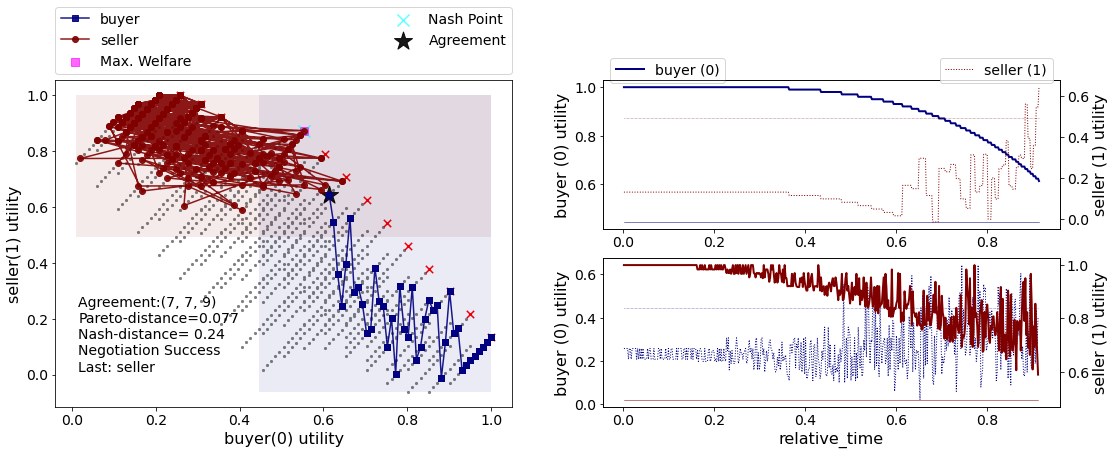

In [22]:
# create negotiation agenda (issues)
issues = [ make_issue(name='price', values=10), 
           make_issue(name='quantity', values=(1, 11)), 
           make_issue(name='delivery_time', values=10) ]
# create the mechanism
session = SAOMechanism(issues=issues, n_steps=500)
# define buyer and seller utilities
buyer_utility = LinearAdditiveUtilityFunction(
        values={ 'price': AffineFun(-1, bias=9.0), 'quantity': LinearFun(0.2),  'delivery_time': IdentityFun() },
        outcome_space=session.outcome_space, reserved_value=9).scale_max(1.0)

seller_utility =  LinearAdditiveUtilityFunction(
        values=[ IdentityFun(),  LinearFun(0.2),  lambda x: math.sin(2 * math.pi * x / 10)  ],
        outcome_space=session.outcome_space, reserved_value=6).scale_max(1.0)

# create and add buyer and seller negotiators
session.add(BoulwareTBNegotiator(name='buyer'), ufun=buyer_utility)
session.add(CosNegotiator(name='seller', preferences=seller_utility))

# run the negotiation and show the results
session.run(); session.plot(show_agreement=True)
savefig("buyerseller_cos3")